Download datasets locally

In [ ]:
# Install kagglehub package
%pip install kagglehub

import kagglehub

In [ ]:
# Download latest version
path = kagglehub.dataset_download("dinoanastasopoulos/gorickyourself") # It downloads the 3 of the datasets (1080/512/256)

print("Path to dataset files:", path)

Rick Images Generator

In [1]:
%pip install torch torchvision matplotlib
# Import necessary libraries 
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.0/865.0 MB 45.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 49.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 41.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 45.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 47.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 48.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 49.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━

In [44]:
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [69]:
dataPath = "data_edited/"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this size using a transformer.
image_size = 256

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input) 
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 50

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

Using device: cpu


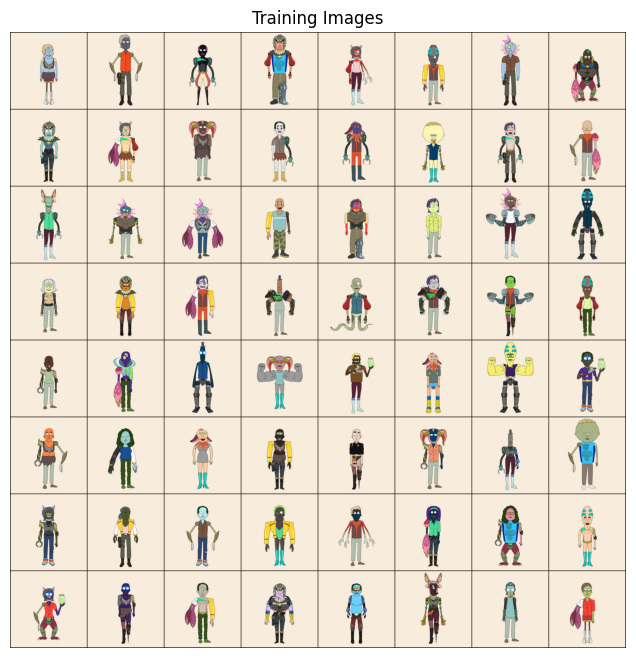

In [70]:
dataset = dset.ImageFolder(root=dataPath,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print("Using device:", device)

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [71]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d(ngf, ngf // 2, 4, 2, 1, bias=False),  # -> 64x64 ← new
            nn.BatchNorm2d(ngf // 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf // 2, ngf // 4, 4, 2, 1, bias=False),  # -> 128x128 ← new
            nn.BatchNorm2d(ngf // 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf // 4, nc, 4, 2, 1, bias=False),  # -> 256x256
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [72]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(

In [73]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
        # New first layers:
        nn.Conv2d(nc, ndf // 4, 4, 2, 1, bias=False),  # 256 -> 128
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(ndf // 4, ndf // 2, 4, 2, 1, bias=False),  # 128 -> 64
        nn.BatchNorm2d(ndf // 2),
        nn.LeakyReLU(0.2, inplace=True),

        # Continue as before, just with updated channel sizes
        nn.Conv2d(ndf // 2, ndf, 4, 2, 1, bias=False),  # 64 -> 32
        nn.BatchNorm2d(ndf),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),  # 32 -> 16
        nn.BatchNorm2d(ndf * 2),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),  # 16 -> 8
        nn.BatchNorm2d(ndf * 4),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),  # 8 -> 4
        nn.BatchNorm2d(ndf * 8),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),  # 4 -> 1
        nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [74]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(256, eps=1e-05, moment

In [75]:
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [76]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
        
os.makedirs("models", exist_ok=True)

# Path
model_path = "models/rickGeneratorModel.pth"

torch.save(netG.state_dict(), model_path)
print("Model saved to", model_path)

Starting Training Loop...
[0/50][0/79]	Loss_D: 1.2214	Loss_G: 4.9005	D(x): 0.6574	D(G(z)): 0.4729 / 0.0109
[0/50][50/79]	Loss_D: 0.0001	Loss_G: 42.5423	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[1/50][0/79]	Loss_D: 0.0003	Loss_G: 42.2868	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000
[1/50][50/79]	Loss_D: 0.0000	Loss_G: 42.1272	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/50][0/79]	Loss_D: 0.0000	Loss_G: 42.1136	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/50][50/79]	Loss_D: 0.0001	Loss_G: 41.9978	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[3/50][0/79]	Loss_D: 0.0000	Loss_G: 41.9850	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/50][50/79]	Loss_D: 0.0000	Loss_G: 42.0321	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/50][0/79]	Loss_D: 0.0000	Loss_G: 41.9470	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/50][50/79]	Loss_D: 0.0000	Loss_G: 41.8949	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[5/50][0/79]	Loss_D: 0.0000	Loss_G: 41.9673	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[5/50][50/79]	Loss_D: 0.0000	Loss_G: 41.8550	D(x): 1.0000	D(G(z)): 0

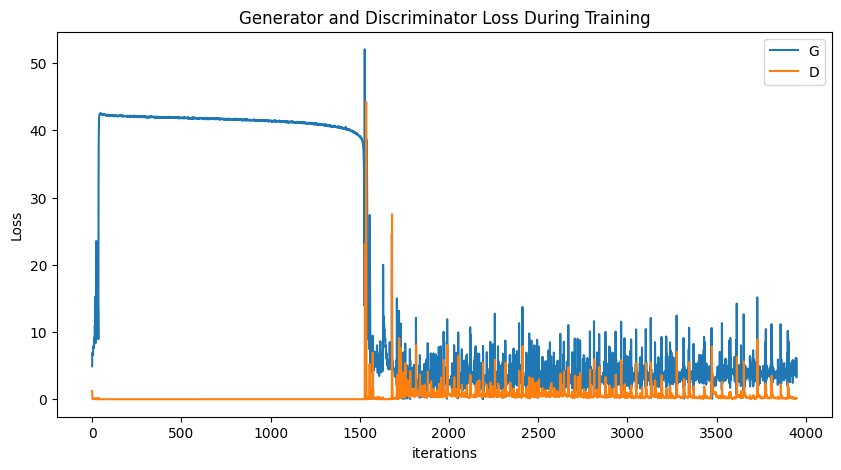

In [77]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

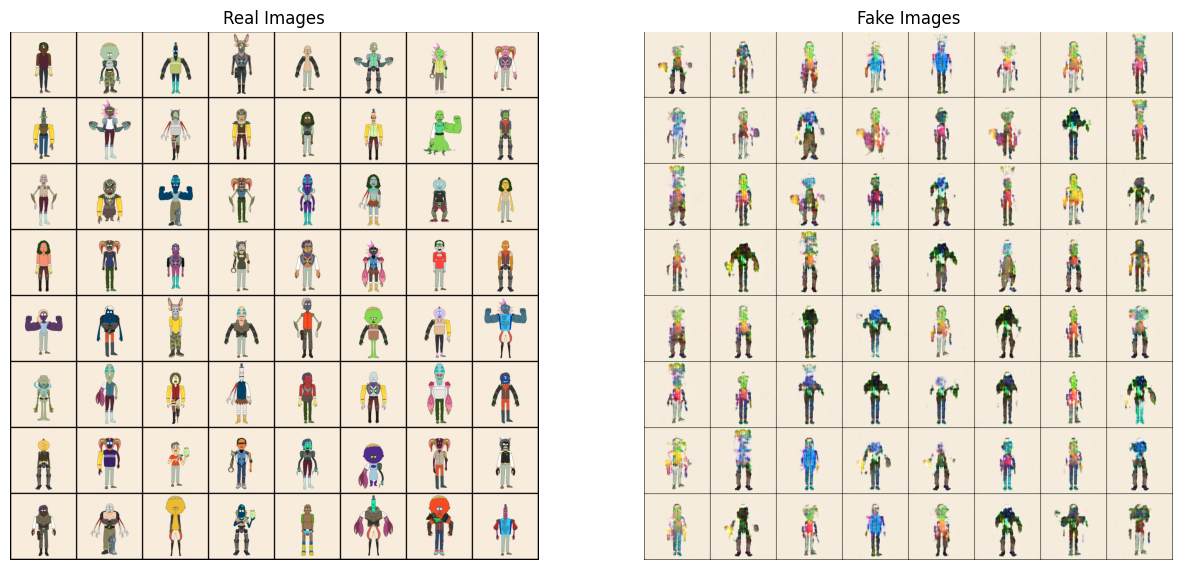

In [78]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

Evaluating generator performance...
Average discriminator score for fake images: 0.0971
Percentage of images that 'fool' the discriminator: 0.00%


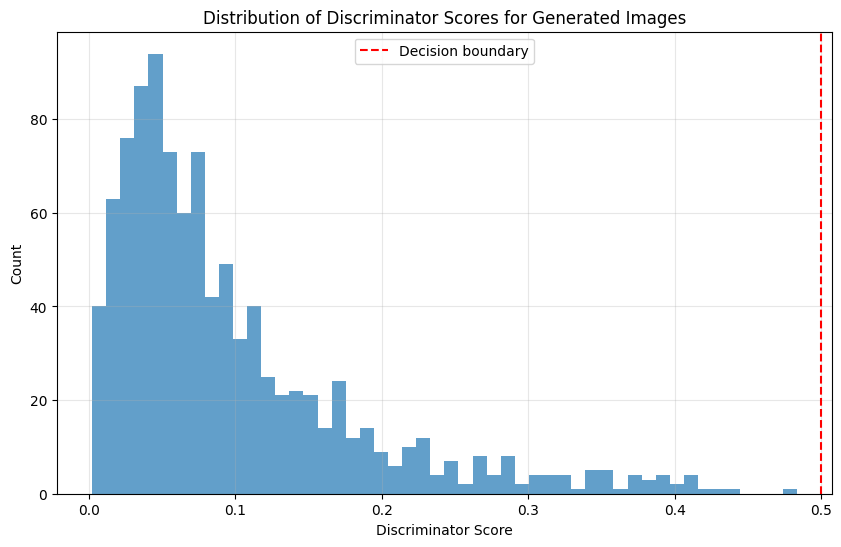

Average discriminator score for real images: 0.9759


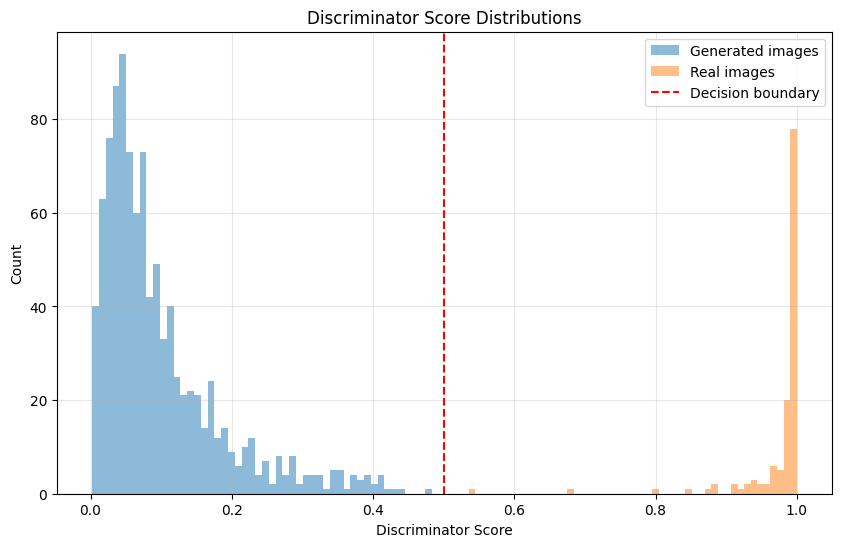

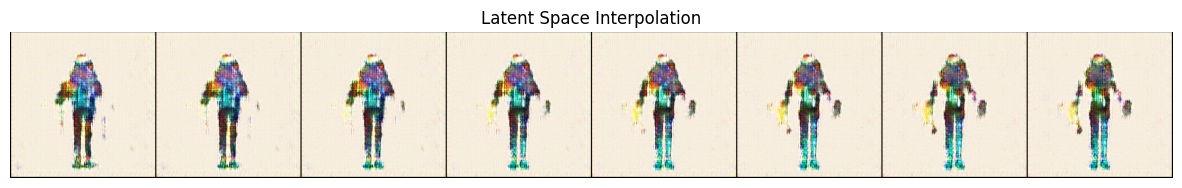

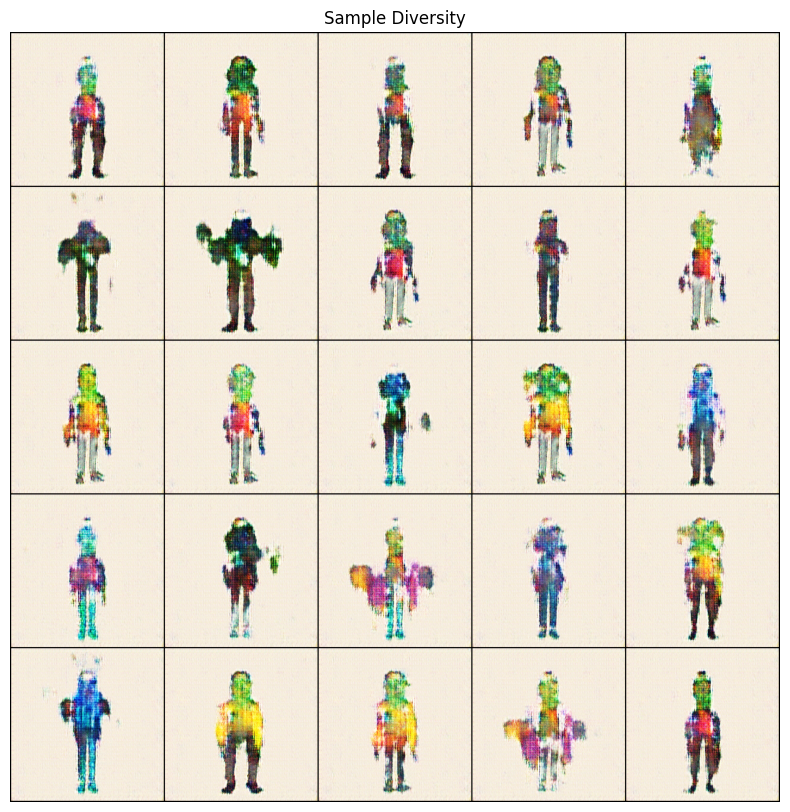


Summary Statistics:
Metric                         Value     
------------------------------ ----------
Generator Fooling Rate (%)     0.00      
Avg. Disc. Score (Fake)        0.0971    
Avg. Disc. Score (Real)        0.9759    
Score Gap (Real-Fake)          0.8788    


In [79]:
# Measure accuracy of the generator using the discriminator
print("Evaluating generator performance...")

# Generate a large batch of images for evaluation
num_test_samples = 1000
test_noise = torch.randn(num_test_samples, nz, 1, 1, device=device)
with torch.no_grad():
    generated_images = netG(test_noise)

# Get discriminator scores for fake images
disc_scores = netD(generated_images).view(-1)
avg_disc_score = disc_scores.mean().item()
print(f"Average discriminator score for fake images: {avg_disc_score:.4f}")

# Calculate how many images "fool" the discriminator (score > 0.5)
fooling_rate = (disc_scores > 0.5).float().mean().item() * 100
print(f"Percentage of images that 'fool' the discriminator: {fooling_rate:.2f}%")

# Histogram of discriminator scores - FIXED: detach tensor before numpy conversion
plt.figure(figsize=(10, 6))
plt.hist(disc_scores.detach().cpu().numpy(), bins=50, alpha=0.7)
plt.axvline(x=0.5, color='red', linestyle='--', label='Decision boundary')
plt.xlabel('Discriminator Score')
plt.ylabel('Count')
plt.title('Distribution of Discriminator Scores for Generated Images')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Get discriminator scores for real images
real_batch = next(iter(dataloader))
real_images = real_batch[0].to(device)
with torch.no_grad():  # Add no_grad here to prevent gradient tracking
    real_disc_scores = netD(real_images).view(-1)
avg_real_disc_score = real_disc_scores.mean().item()
print(f"Average discriminator score for real images: {avg_real_disc_score:.4f}")

# Compare score distributions - FIXED: detach tensors before numpy conversion
plt.figure(figsize=(10, 6))
plt.hist(disc_scores.detach().cpu().numpy(), bins=50, alpha=0.5, label='Generated images')
plt.hist(real_disc_scores.detach().cpu().numpy(), bins=50, alpha=0.5, label='Real images')
plt.axvline(x=0.5, color='red', linestyle='--', label='Decision boundary')
plt.xlabel('Discriminator Score')
plt.ylabel('Count')
plt.title('Discriminator Score Distributions')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Generate a grid of images with gradually changing noise
# This helps visualize the latent space
interpolation_samples = 8
z1 = torch.randn(1, nz, 1, 1, device=device)
z2 = torch.randn(1, nz, 1, 1, device=device)

interpolated_images = []
alphas = np.linspace(0, 1, interpolation_samples)

for alpha in alphas:
    z_interp = z1 * (1 - alpha) + z2 * alpha
    with torch.no_grad():
        img = netG(z_interp)
        interpolated_images.append(img.cpu())

# Create a grid of the interpolated images
interpolated_grid = vutils.make_grid(torch.cat(interpolated_images), nrow=interpolation_samples, padding=2, normalize=True)
plt.figure(figsize=(15, 4))
plt.axis("off")
plt.title("Latent Space Interpolation")
plt.imshow(np.transpose(interpolated_grid, (1, 2, 0)))
plt.show()

# Generate multiple images and visualize their diversity
diverse_samples = 25
diverse_noise = torch.randn(diverse_samples, nz, 1, 1, device=device)
with torch.no_grad():
    diverse_images = netG(diverse_noise)

diverse_grid = vutils.make_grid(diverse_images, nrow=5, padding=2, normalize=True)
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Sample Diversity")
plt.imshow(np.transpose(diverse_grid, (1, 2, 0)))
plt.show()

# Calculate and print summary statistics
print("\nSummary Statistics:")
print(f"{'Metric':<30} {'Value':<10}")
print(f"{'-'*30} {'-'*10}")
print(f"{'Generator Fooling Rate (%)':<30} {fooling_rate:<10.2f}")
print(f"{'Avg. Disc. Score (Fake)':<30} {avg_disc_score:<10.4f}")
print(f"{'Avg. Disc. Score (Real)':<30} {avg_real_disc_score:<10.4f}")
print(f"{'Score Gap (Real-Fake)':<30} {avg_real_disc_score - avg_disc_score:<10.4f}")

  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 47.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 42.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 767.5/767.5 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 38.9 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 MB 42.1 MB/s eta 0:00:0000:0100:01
Using cached markdown_it_py-3.0.0-py3-none-any.whl (87 kB)
Using cached mdurl-0.1.2-py3-none-any.whl (10.0 kB)
Note: you may need to restart the kernel to use updated packages.


/home/ud/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


* Running on local URL:  http://127.0.0.1:7860
Using cache from '/home/ud/Documentos/deeplearning/RickImagesGenerator/.gradio/cached_examples/12' directory. If method or examples have changed since last caching, delete this folder to clear cache.

* Running on public URL: https://16d992968b75941ff9.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "/home/ud/miniconda3/lib/python3.12/site-packages/gradio/queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ud/miniconda3/lib/python3.12/site-packages/gradio/route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ud/miniconda3/lib/python3.12/site-packages/gradio/blocks.py", line 2156, in process_api
    data = await self.postprocess_data(block_fn, result["prediction"], state)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ud/miniconda3/lib/python3.12/site-packages/gradio/blocks.py", line 1956, in postprocess_data
    outputs_cached = await processing_utils.async_move_files_to_cache(
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ud/miniconda3/lib/python3.1

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://16d992968b75941ff9.gradio.live
Saved 16 images to best_ricks/


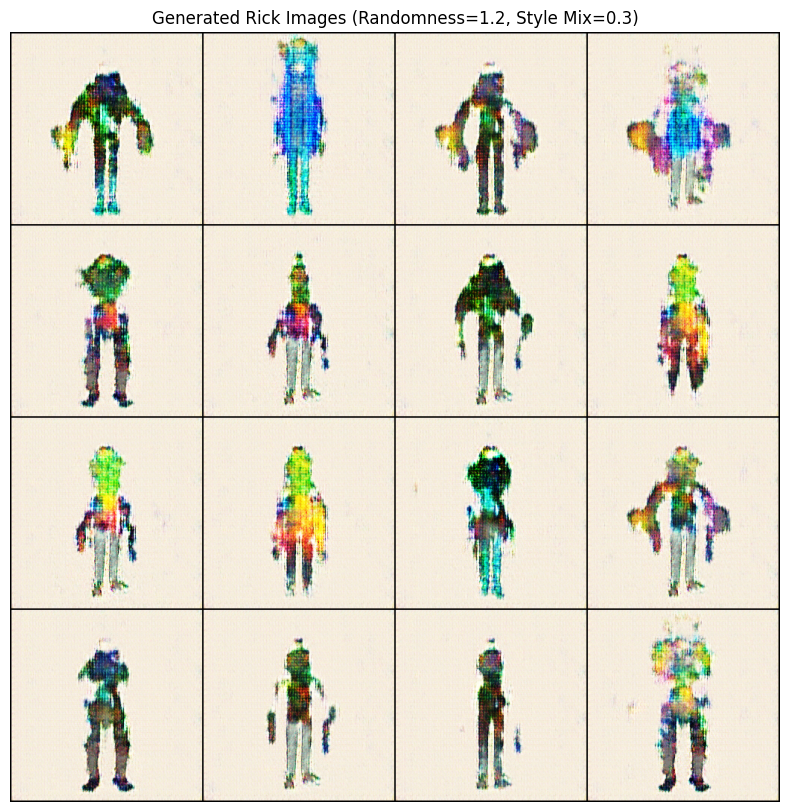

'Saved images to best_ricks/'

In [80]:
# Install Gradio
%pip install gradio
import gradio as gr
import torch
import numpy as np
from torchvision import transforms

# Path to save the model
model_path = "models/rickGeneratorModel.pth"

# Load the trained generator model
def load_model():
    # Create the generator
    loaded_netG = Generator(ngpu).to(device)
    # Load the trained parameters
    loaded_netG.load_state_dict(torch.load(model_path))
    loaded_netG.eval()
    return loaded_netG

# Generate images function
def generate_rick_images(num_images, randomness, style_mixing=0.0):
    # Set up the generator model
    model = load_model()
    
    # Create latent vectors with adjustable randomness
    noise_factor = randomness * 2  # Scale 0-1 to 0-2 for better control
    z = torch.randn(num_images, nz, 1, 1, device=device) * noise_factor
    
    # If style mixing is enabled, generate a second batch of noise vectors and mix them
    if style_mixing > 0:
        z2 = torch.randn(num_images, nz, 1, 1, device=device) * noise_factor
        # Mix the two noise vectors based on the style_mixing parameter
        z = z * (1 - style_mixing) + z2 * style_mixing
    
    # Generate images
    with torch.no_grad():
        fake_images = model(z)
    
    # Convert to numpy and adjust format for display
    images_cpu = fake_images.detach().cpu()
    images_grid = vutils.make_grid(images_cpu, nrow=int(np.sqrt(num_images)), padding=2, normalize=True)
    img_array = np.transpose(images_grid.numpy(), (1, 2, 0))
    
    # Make sure the values are in the right range for displaying
    img_array = (img_array * 255).astype(np.uint8)
    
    return img_array

# Create a Gradio interface for the image generator
def create_interface():
    # Define the interface inputs
    with gr.Blocks(title="Rick and Morty Image Generator") as demo:
        gr.Markdown("## Rick Image Generator GAN")
        gr.Markdown("Generate realistic Rick images using a trained GAN model")
        
        with gr.Row():
            with gr.Column():
                # Input controls
                num_images = gr.Slider(minimum=1, maximum=25, value=9, step=1, label="Number of Images", info="How many images to generate")
                randomness = gr.Slider(minimum=0.1, maximum=2.0, value=1.0, step=0.1, label="Randomness", info="How random the generated images should be")
                style_mix = gr.Slider(minimum=0, maximum=1.0, value=0.0, step=0.05, label="Style Mixing", info="Mix between two random styles")
                generate_btn = gr.Button("Generate Images")
            
            with gr.Column():
                # Output display
                output_image = gr.Image(label="Generated Rick Images")
        
        # Connect the button to the generator function
        generate_btn.click(
            fn=generate_rick_images,
            inputs=[num_images, randomness, style_mix],
            outputs=output_image
        )
        
        # Initial example for display
        gr.Examples(
            [[9, 1.0, 0.0], [16, 0.8, 0.3], [4, 1.5, 0.5]],
            [num_images, randomness, style_mix],
            output_image,
            fn=generate_rick_images,
            cache_examples=True,
            label="Example Configurations"
        )
        
        gr.Markdown("### Advanced Use Tips")
        gr.Markdown("- Increase randomness for more varied features")
        gr.Markdown("- Use style mixing to blend characteristics between different Rick variants")
        gr.Markdown("- Generate multiple images to pick your favorite Rick!")
    
    return demo

# Launch the interactive interface
demo = create_interface()
demo.launch(debug=True, share=True)

# Function to generate and save specific images
def generate_and_save_images(num_images=16, randomness=1.0, style_mix=0.0, save_folder="generated_ricks"):
    # Create folder if it doesn't exist
    import os
    os.makedirs(save_folder, exist_ok=True)
    
    # Set up the generator model
    model = load_model()
    
    # Create latent vectors
    noise_factor = randomness * 2
    z = torch.randn(num_images, nz, 1, 1, device=device) * noise_factor
    
    if style_mix > 0:
        z2 = torch.randn(num_images, nz, 1, 1, device=device) * noise_factor
        z = z * (1 - style_mix) + z2 * style_mix
    
    # Generate images
    with torch.no_grad():
        fake_images = model(z)
    
    # Convert and save individual images
    transform = transforms.ToPILImage()
    for i, img_tensor in enumerate(fake_images):
        img_normalized = (img_tensor.cpu() + 1) / 2.0  # Normalize from [-1,1] to [0,1]
        img_pil = transform(img_normalized)
        img_pil.save(f"{save_folder}/rick_generated_{i+1}.png")
    
    print(f"Saved {num_images} images to {save_folder}/")
    
    # Display grid of saved images
    grid = vutils.make_grid(fake_images, nrow=int(np.sqrt(num_images)), padding=2, normalize=True)
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.title(f"Generated Rick Images (Randomness={randomness}, Style Mix={style_mix})")
    plt.imshow(np.transpose(grid.cpu(), (1, 2, 0)))
    plt.savefig(f"{save_folder}/rick_grid.png", bbox_inches='tight')
    plt.show()

    return f"Saved images to {save_folder}/"

# Save a batch of your favorite Rick images
generate_and_save_images(num_images=16, randomness=1.2, style_mix=0.3, save_folder="best_ricks")